In [3]:
!nvidia-smi

Fri Jun 20 11:05:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
|  0%   41C    P8             11W /  450W |    3170MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import argparse

class Args(argparse.Namespace):
    image_size=256
    centered=True
    num_channels_dae=64
    n_mlp=3
    ch_mult=[1,1,2,2,4,4]
    num_res_blocks=2
    attn_resolutions=(16,)
    dropout=0.
    resamp_with_conv=True
    conditional=True
    fir=True
    fir_kernel=[1, 3, 3, 1]
    skip_rescale=True
    resblock_type='biggan'
    progressive='none'
    progressive_input='residual'
    progressive_combine='sum'
    embedding_type='positional'
    fourier_scale=16.
    not_use_tanh=False
    z_emb_dim=256
    nz=100
    ngf=64
    num_channels=3
    batch_size=32
    
    
args=Args()

In [2]:
import os, sys
# sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

# from src import distributions
import torch.nn.functional as F

from src.models.resnet import ResNet_D
from src.models.unet import UNet
from src.models.u2net import U2NET, U2NETP, EMA

from src.dataset.dataset import unfreeze, freeze, weights_init_D, load_dataset, load_celeba
from src.metrics.fid_score import calculate_frechet_distance
from src.metrics.inception import InceptionV3
# from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.dataset.dataset import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [3]:
torch.__version__

'2.3.0'

In [4]:
def get_pushed_loader_stats_old(T, loader, batch_size=8, verbose=False, device='cuda',
                            use_downloaded_weights=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    freeze(model); freeze(T)
    
    size = len(loader.dataset)
    pred_arr = []
    
    with torch.no_grad():
        for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):
            for i in range(0, len(X), batch_size):
                start, end = i, min(i + batch_size, len(X))
                z = torch.randn(end-start, 100, device=device)
                batch = T(X[start:end].type(torch.FloatTensor).to(device)).add(1).mul(.5)
                pred_arr.append(model(batch)[0].cpu().data.numpy().reshape(end-start, -1))

    pred_arr = np.vstack(pred_arr)
    mu, sigma = np.mean(pred_arr, axis=0), np.cov(pred_arr, rowvar=False)
    gc.collect(); torch.cuda.empty_cache()
    return mu, sigma

def plot_images(X, Y, T):
    freeze(T);
    z = torch.randn(X.size(0), 100).cuda()
    with torch.no_grad():
        T_X = T(X)
        imgs = torch.cat([X, T_X, Y]).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

    fig, axes = plt.subplots(3, 10, figsize=(15, 4.5), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel('X', fontsize=24)
    axes[1, 0].set_ylabel('T(X)', fontsize=24)
    axes[2, 0].set_ylabel('Y', fontsize=24)
    
    fig.tight_layout(pad=0.001)
    torch.cuda.empty_cache(); gc.collect()
    return fig, axes

def plot_random_images(X_sampler, Y_sampler, T):
    X = X_sampler.sample(10)
    Y = Y_sampler.sample(10)
    return plot_images(X, Y, T)

## Main Config

In [5]:
DEVICE_IDS = [0]

# DATASET1, DATASET1_PATH = 'outdoor', '../pSp/datasets/outdoor_128.hdf5'
# DATASET2, DATASET2_PATH = 'church', './datasets/church_128.hdf5'

DATASET1, DATASET1_PATH = 'celeba_male', 'datasets/CelebA_HQ'
DATASET2, DATASET2_PATH = 'celeba_female', 'datasets/CelebA_HQ'

DATASET1, DATASET1_PATH = 'aligned_anime_faces', '/home/gosha20777/Documents/Projects/jmu/sb-experimants/unpaired-isp/data/zrr-rgb/train/2/'
DATASET2, DATASET2_PATH = 'aligned_anime_faces', '/home/gosha20777/Documents/Projects/jmu/sb-experimants/unpaired-isp/data/zrr-rgb/train/1/'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
f_LR, T_LR = 1e-4, 2e-4
IMG_SIZE = 64

BATCH_SIZE = 64

PLOT_INTERVAL = 200
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 1000
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}_uot_kl_batch64'
OUTPUT_PATH = 'checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

## Preparation

In [6]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

# if not os.path.exists(OUTPUT_PATH):
#     os.makedirs(OUTPUT_PATH)

## Prepare Samplers (X, Y)

In [7]:
X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE)
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

#X_sampler = load_celeba('datasets/CelebA_HQ', "male", True, batch_size=BATCH_SIZE)
#X_test_sampler = load_celeba('datasets/CelebA_HQ', "male", False, batch_size=BATCH_SIZE)

#Y_sampler = load_celeba('datasets/CelebA_HQ', "female", True, batch_size=BATCH_SIZE)
#Y_test_sampler = load_celeba('datasets/CelebA_HQ', "female", False, batch_size=BATCH_SIZE)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

20

## Loading data stats for testing

In [8]:
# from src.dataset.dataset import get_loader_stats

# _, test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
# mu, sigma = get_loader_stats(test_sampler.loader, device='cuda', use_downloaded_weights=False)
# stats = {'mu' : mu.tolist(), 'sigma' : sigma.tolist()}
# print('Stats computed')

# filename = '{}_{}_test.json'.format(DATASET2, IMG_SIZE)
# with open(filename, 'w') as fp:
#     json.dump(stats, fp)
# print('Stats saved to {}'.format(filename))

In [9]:
len(Y_sampler.loader)

659

# Initializing Networks

In [10]:
# from src.models.ncsn.models.ncsnpp_generator_adagn import NCSNpp
# T = NCSNpp(args).cuda()

# from src.models.ncsn.models.discriminator import Discriminator_large, Discriminator_small
# f = Discriminator_large(nc=args.num_channels, ngf=args.ngf, act=nn.LeakyReLU(0.2)).cuda()

# print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
# print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

In [11]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --upgrade --force-reinstall

In [12]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=128).cuda()
#T = U2NET(in_ch=3, out_ch=3).cuda()

# if len(DEVICE_IDS) > 1:
#     T = nn.DataParallel(T, device_ids=DEVICE_IDS)
#     f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 69022083
f params: 22927105


In [13]:
mu, sigma = get_pushed_loader_stats_old(T, X_test_sampler.loader)

/home/gosha20777/miniconda3/envs/diffus/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [14]:
import copy

ema = EMA(0.999)
ema_model = copy.deepcopy(T).cuda()

start_ema = 30000

In [15]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

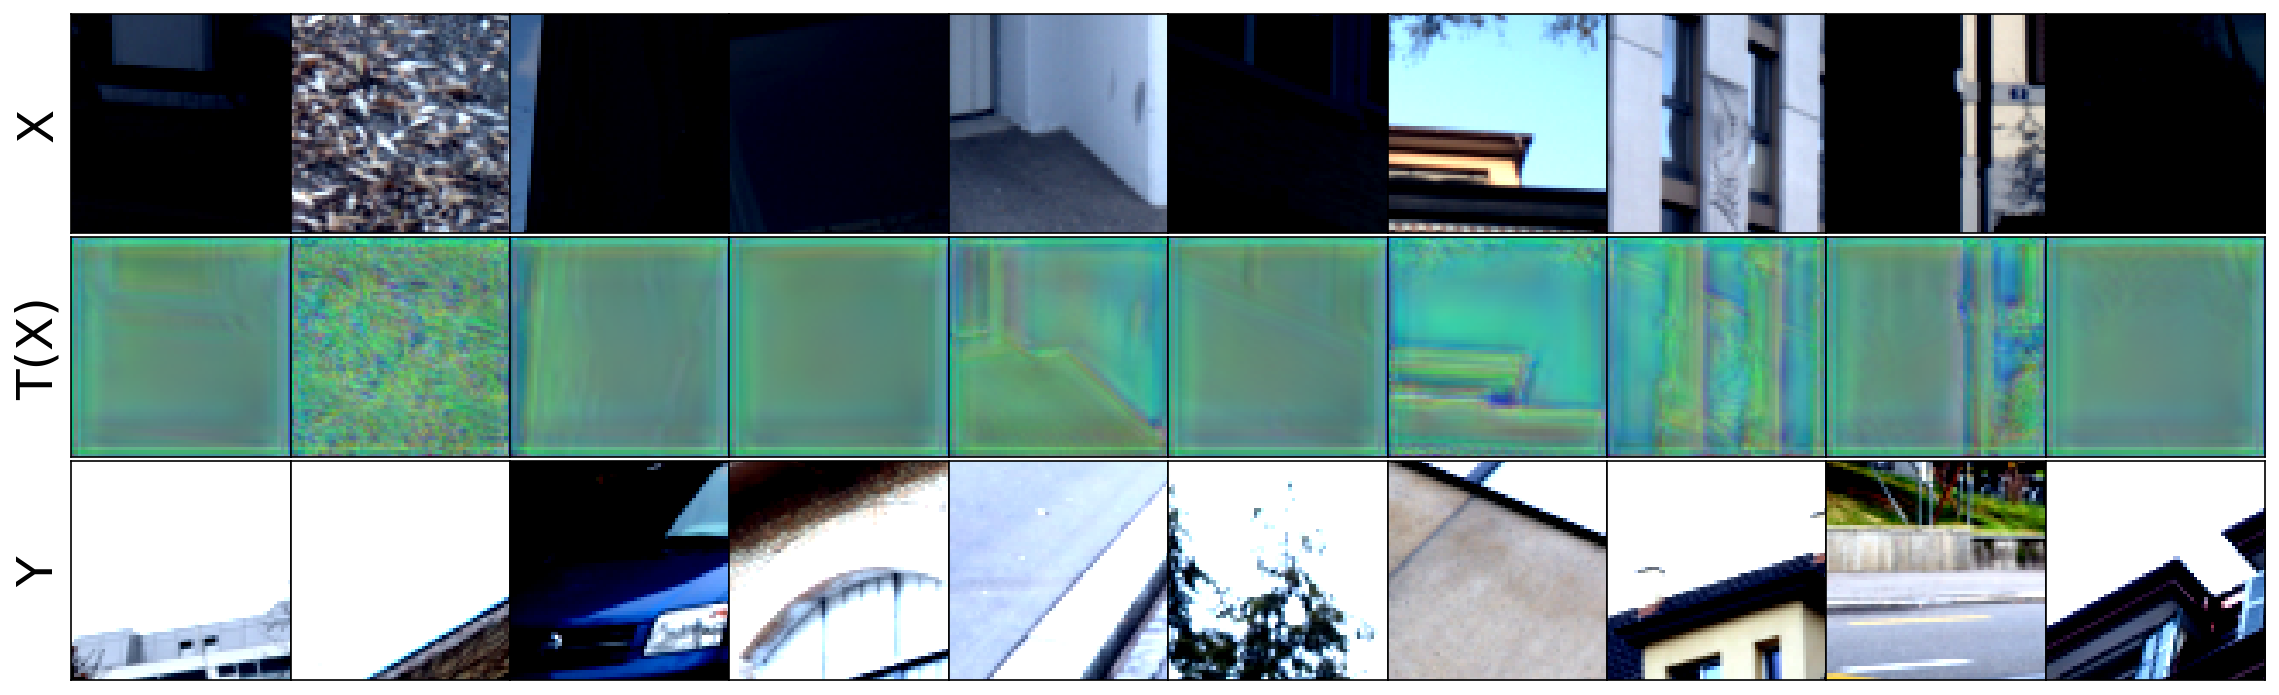

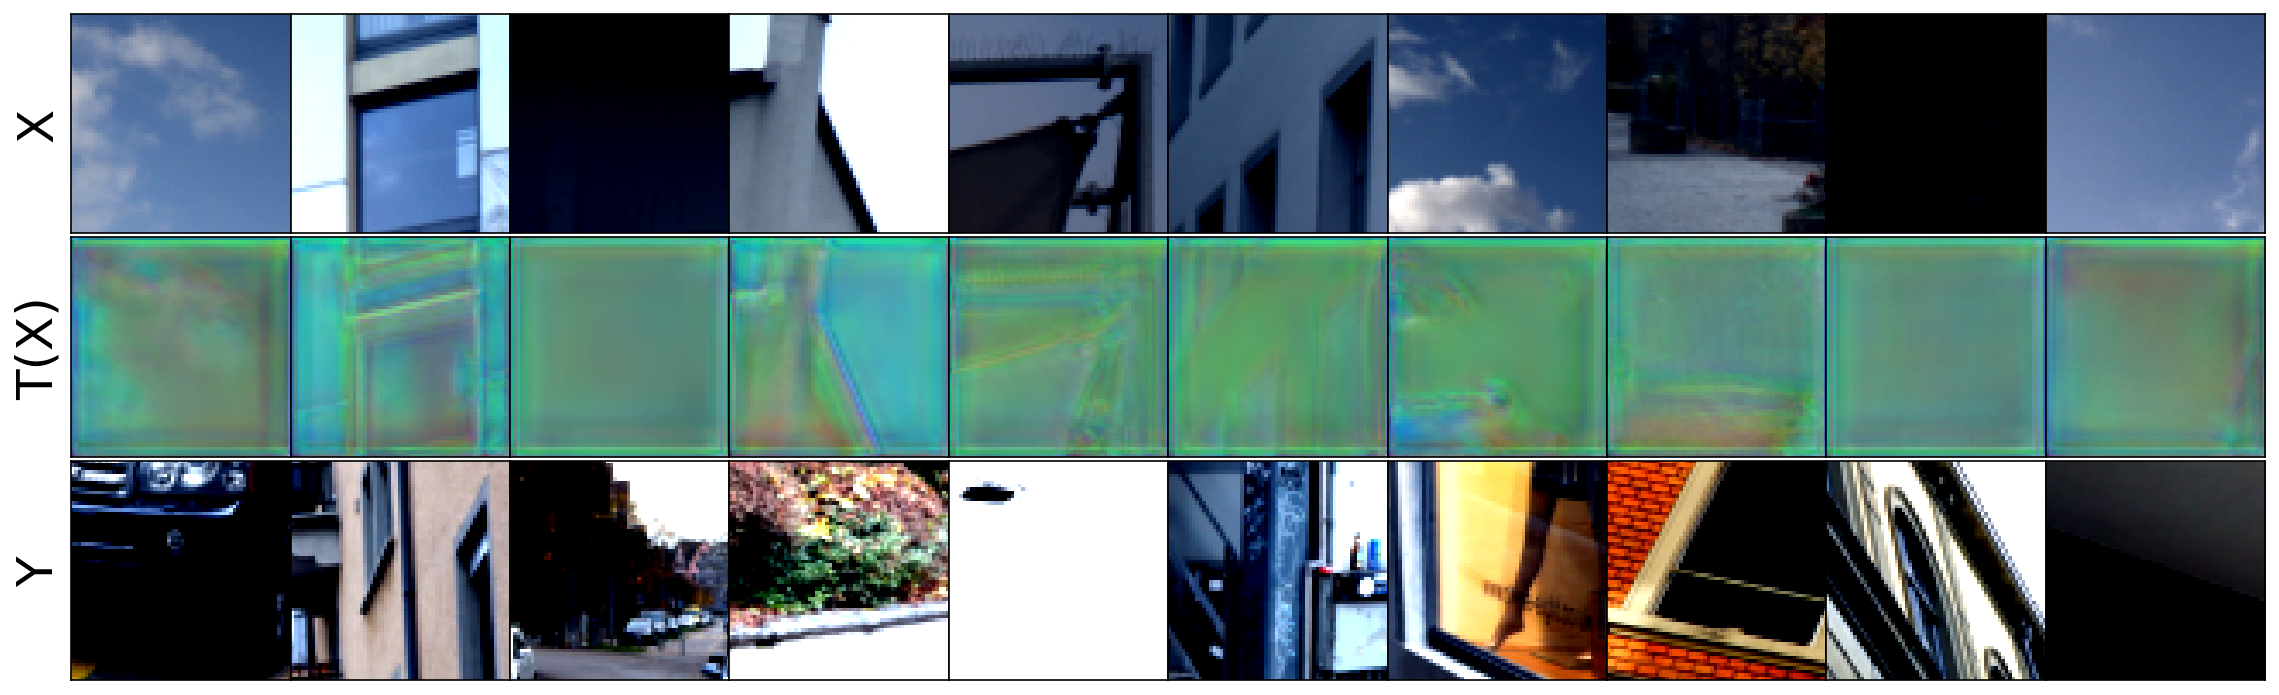

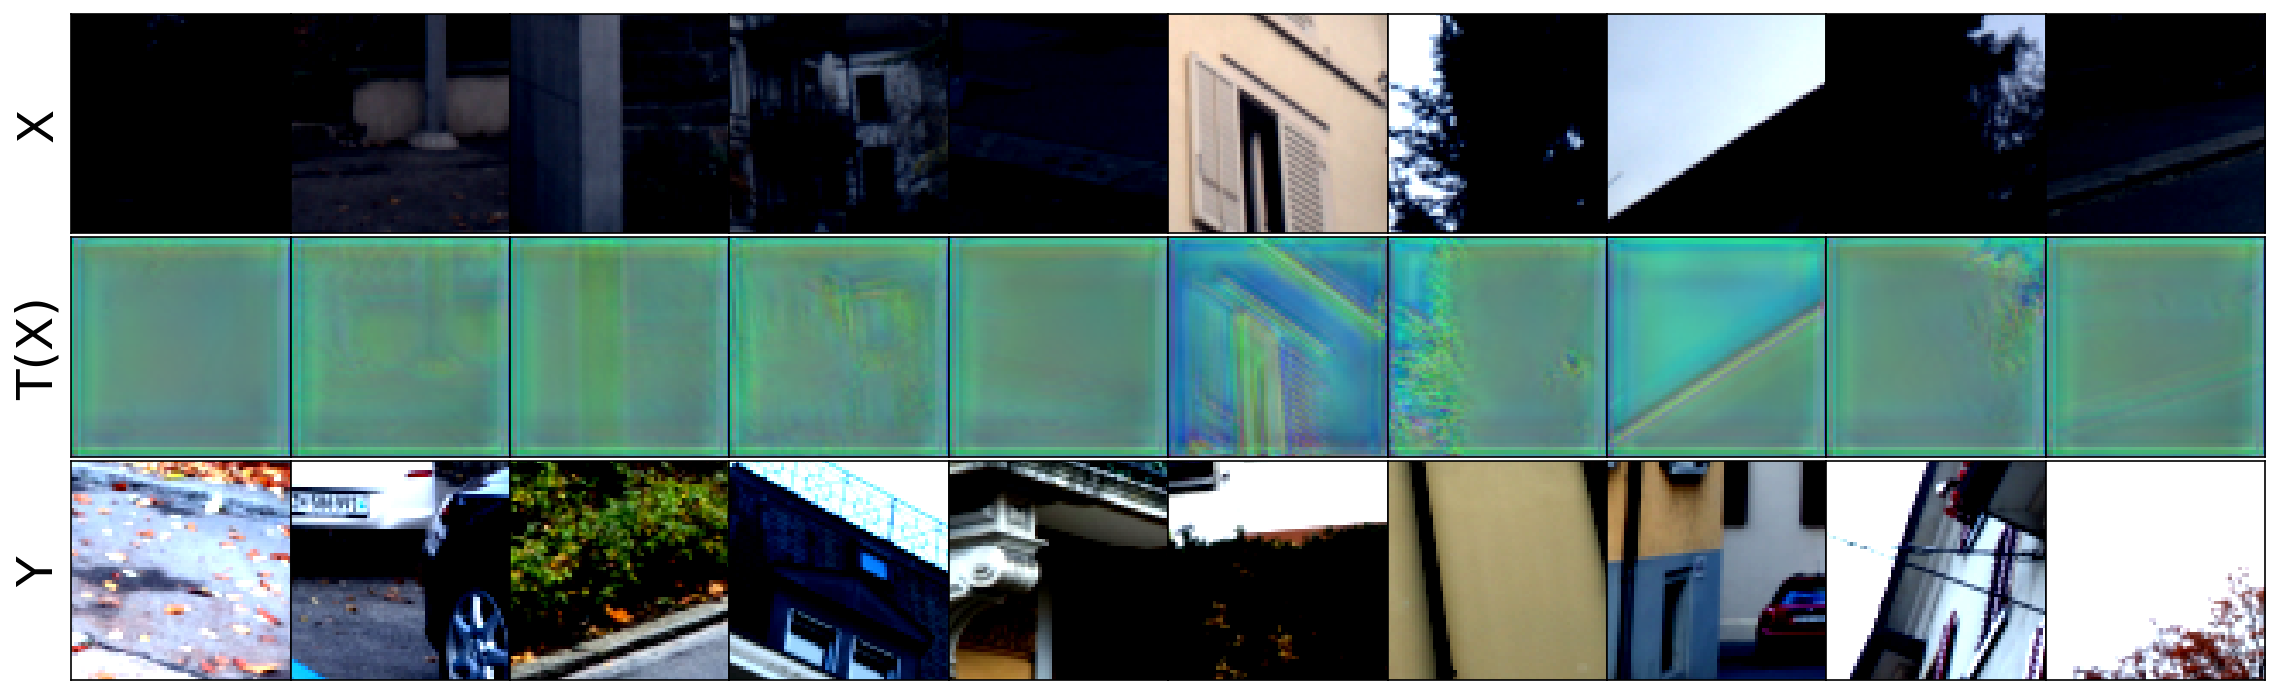

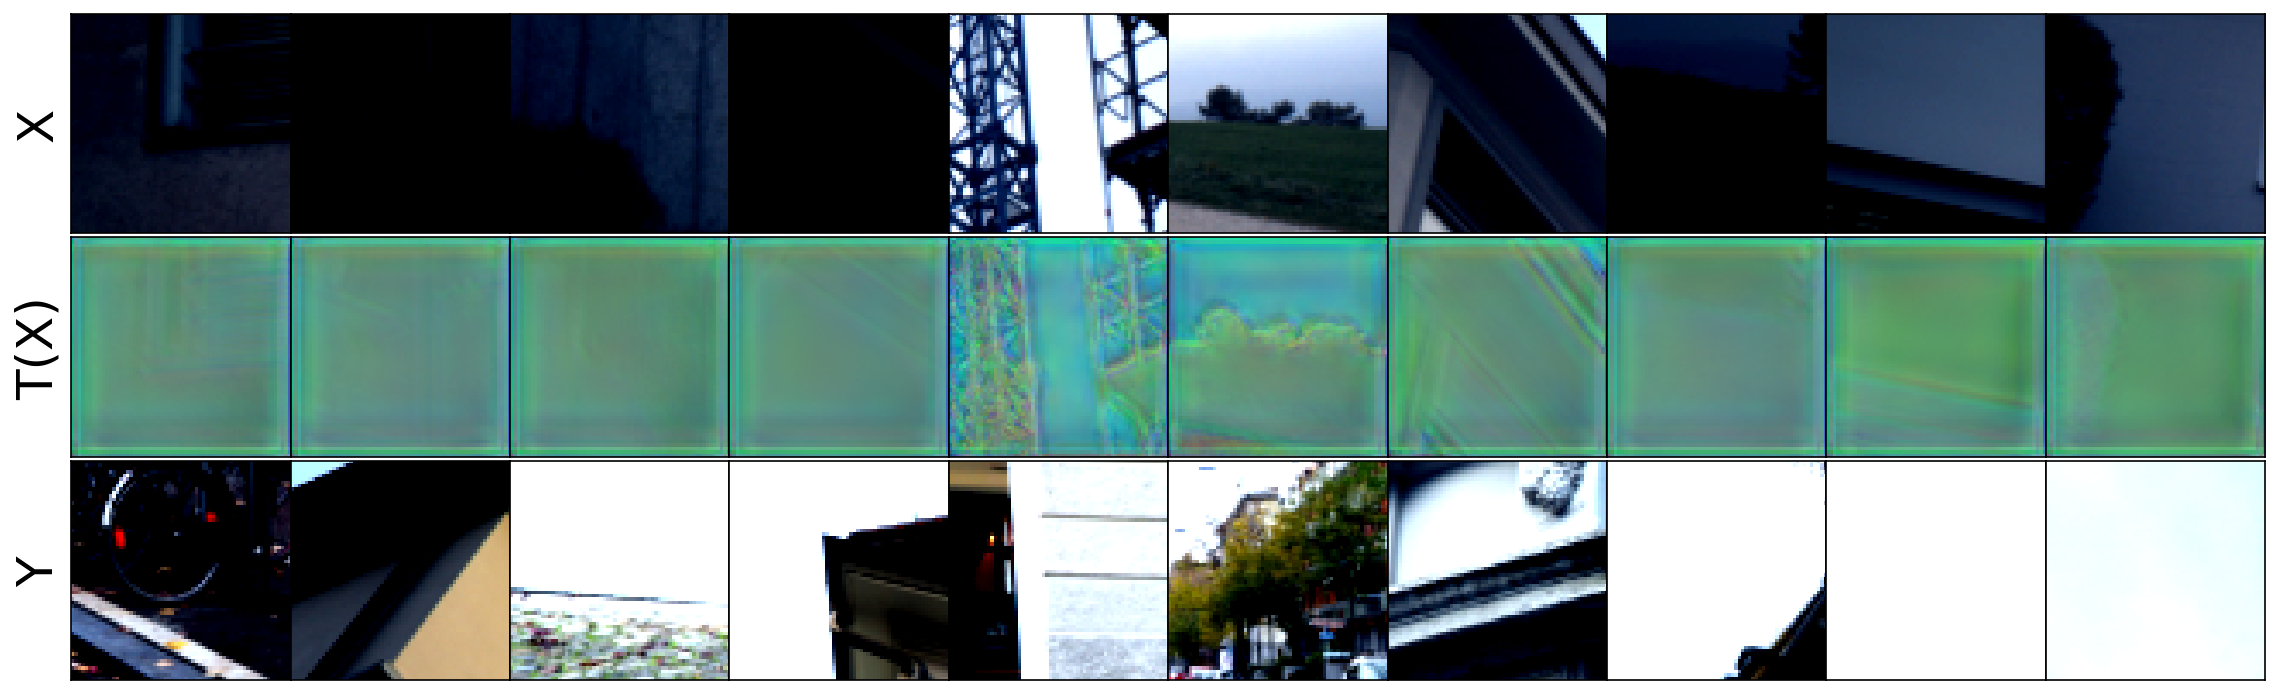

In [16]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Run Training

In [17]:
wandb.init(name=EXP_NAME, project='progressive_growing_OT_first_gpu', config=config)
pass

wandb: Currently logged in as: gosha20777. Use `wandb login --relogin` to force relogin


In [18]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, betas=(0.5, 0.9))
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, betas=(0.5, 0.9))

sch_f = torch.optim.lr_scheduler.CosineAnnealingLR(f_opt, 700, eta_min=1e-5)
sch_T = torch.optim.lr_scheduler.CosineAnnealingLR(T_opt, 700, eta_min=1e-5)

In [19]:
phi1 = lambda x: torch.exp(x)
phi2 = lambda x: torch.exp(x)

tau = 0.00001
r1_gamma = 5

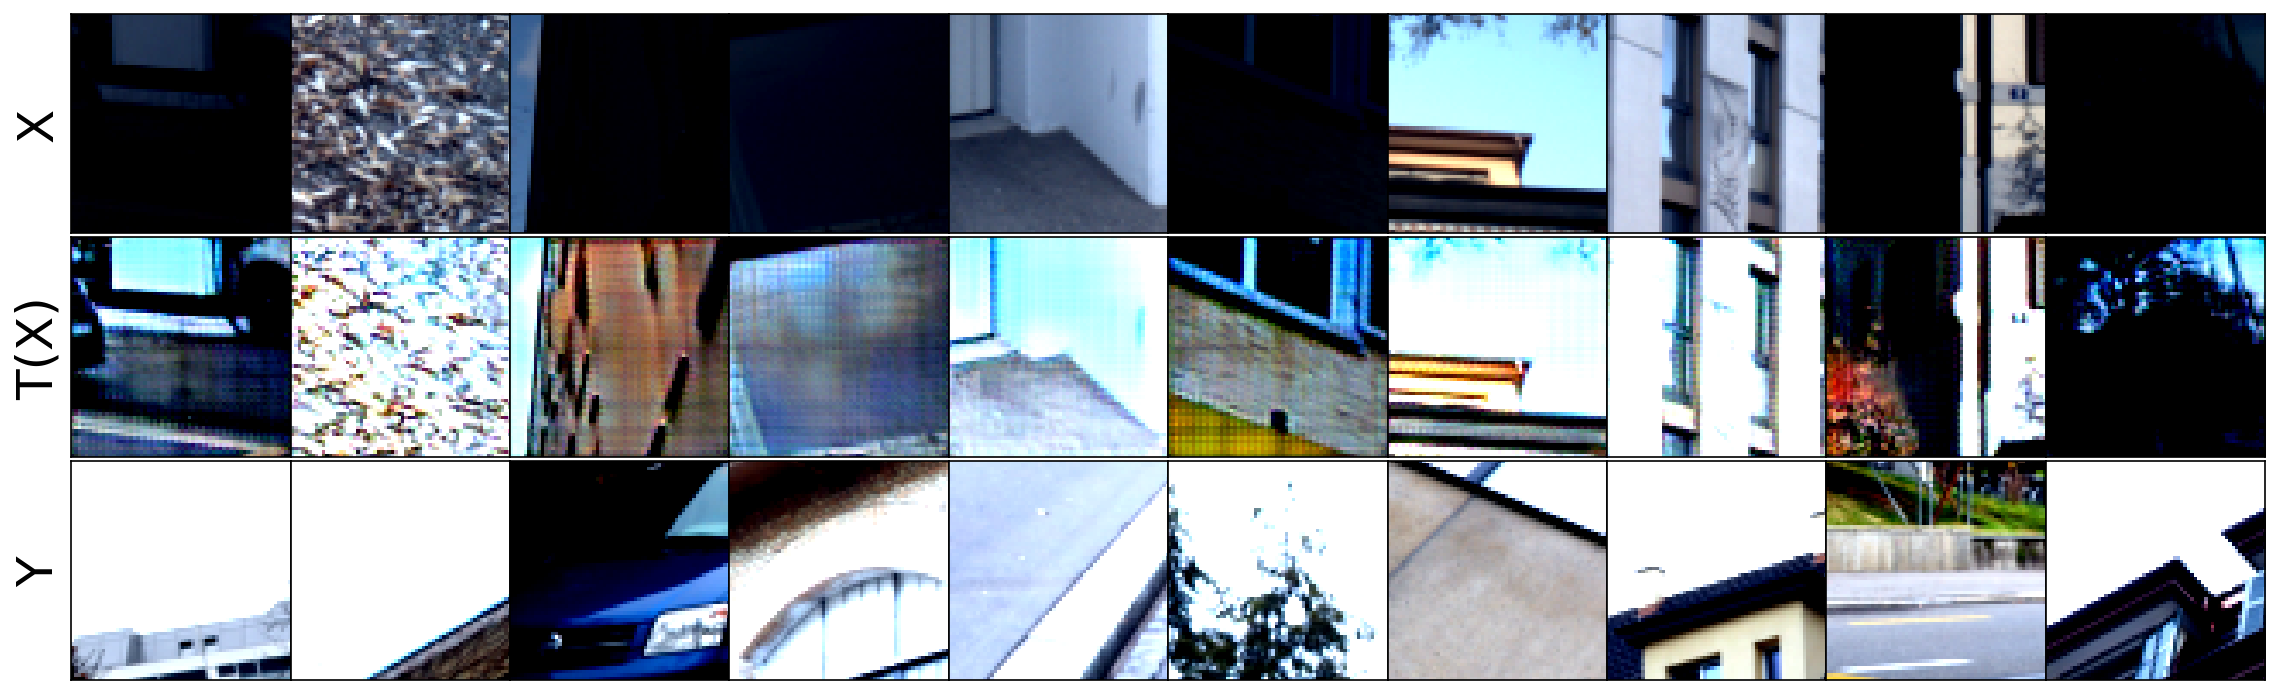

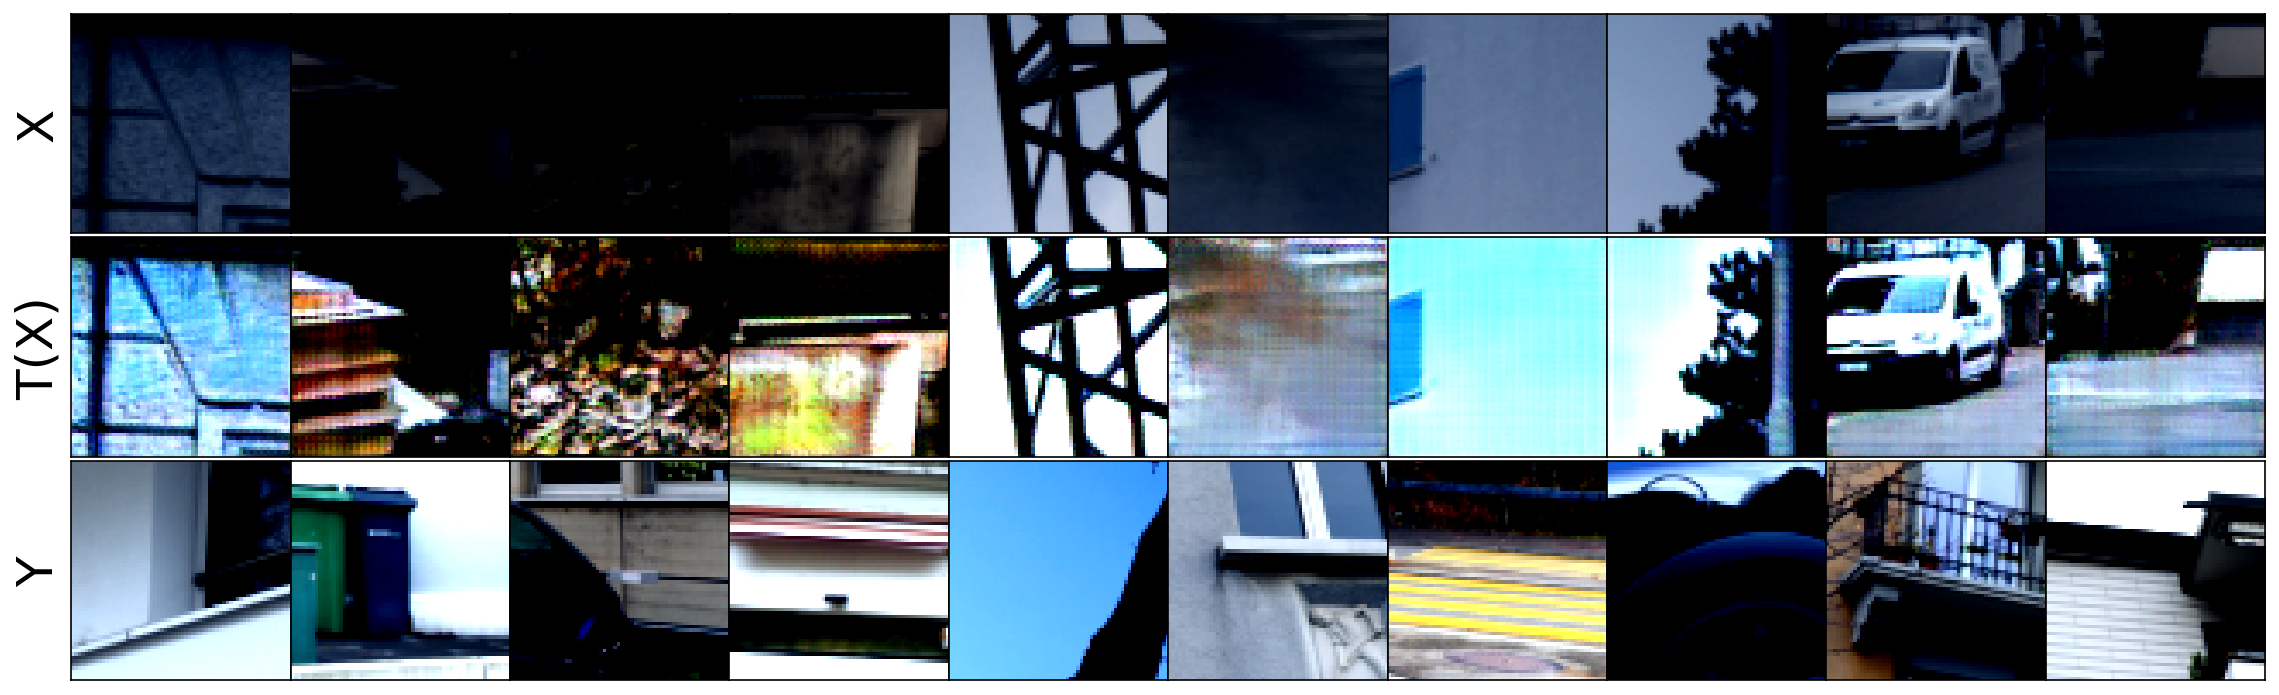

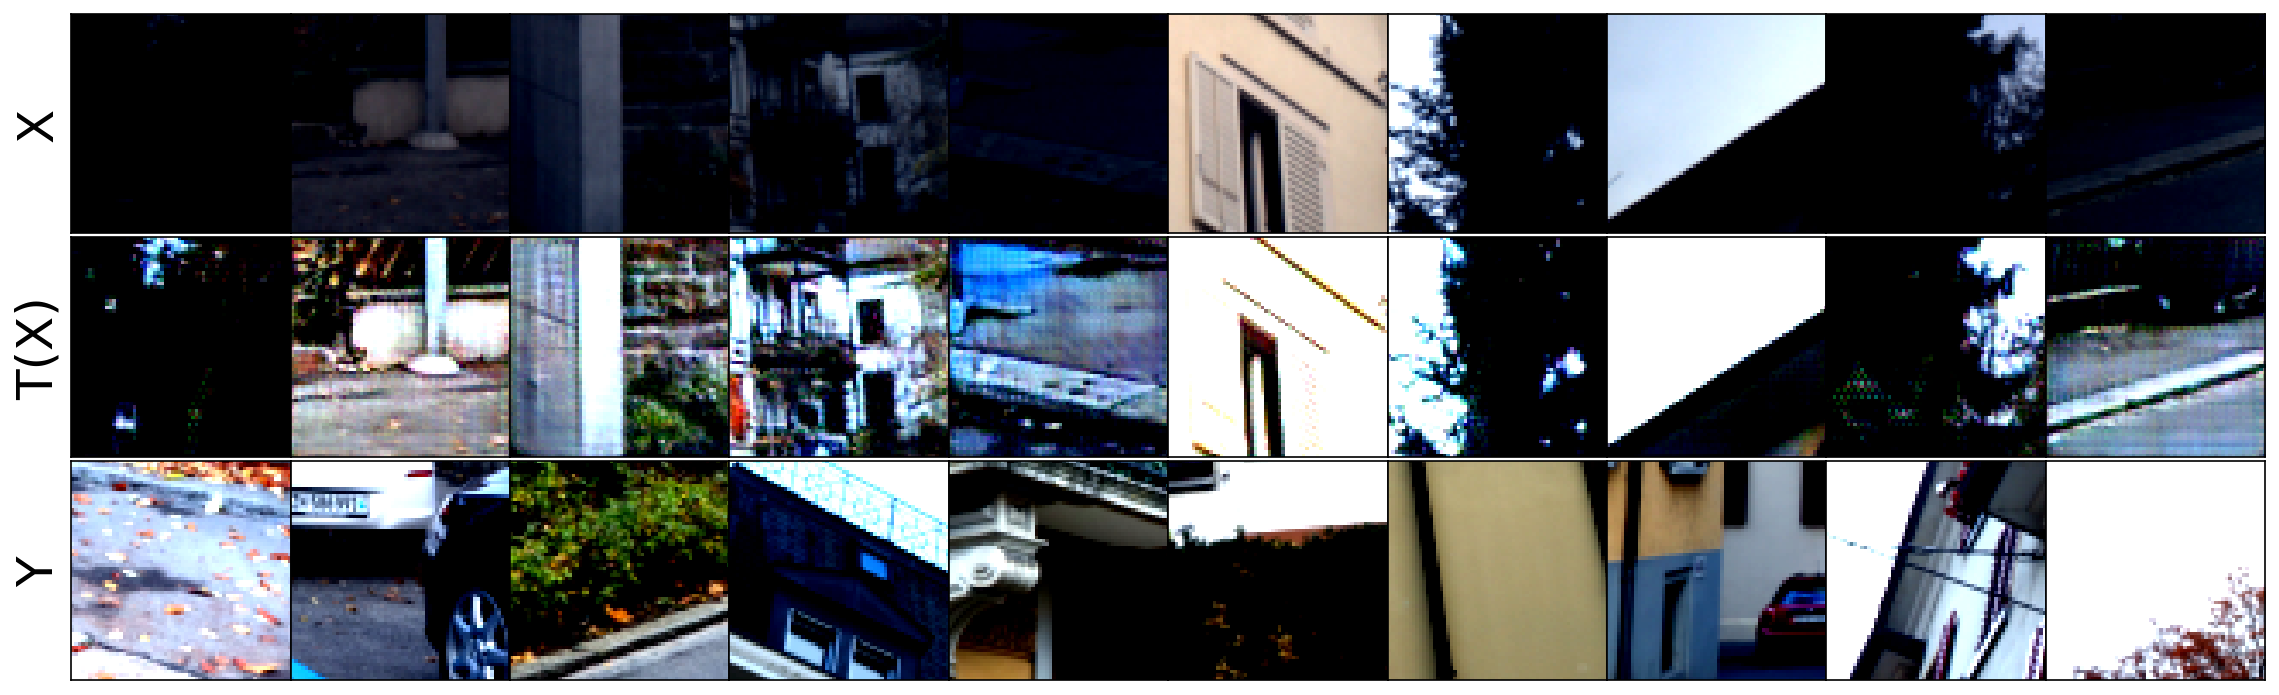

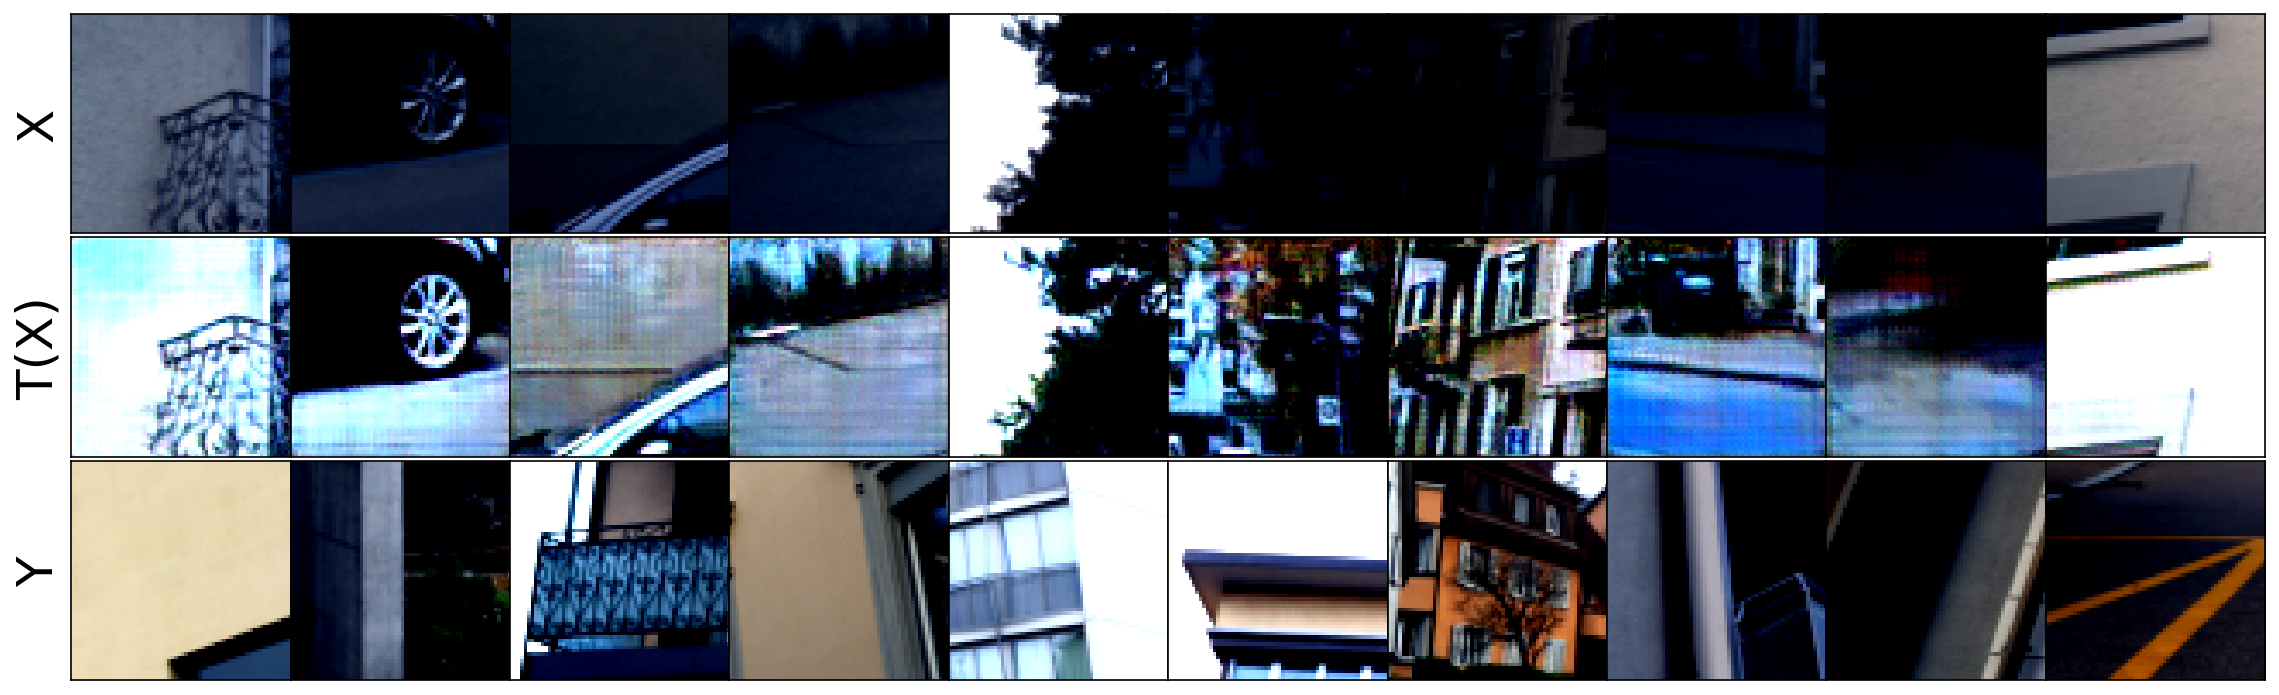

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        z = torch.randn(BATCH_SIZE, args.nz).cuda()
        T_X = T(X)
        if COST == 'mse':
#             T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
            T_loss = (tau * torch.sum(((T_X - X).view(X.size(0), -1))**2, dim=1) - f(T_X)).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    wandb.log({f'T_loss' : T_loss.item()}, step=step)
    del T_loss, T_X, X, z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
#     Y = Y_sampler.sample(BATCH_SIZE)
    z = torch.randn(BATCH_SIZE, args.nz).cuda()
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    Y.requires_grad = True
    f_opt.zero_grad()
    
    f_real = f(Y)
    f_loss_real = phi2(-f_real).mean()
    f_loss_real.backward(retain_graph=True)
    
#     y_push = f(Y)
    grad_ = torch.autograd.grad(outputs=f_real.sum(), inputs=Y, create_graph=True)[0]
    grad_penalty = (grad_.view(grad_.size(0), -1).norm(2, dim=1) ** 2).mean()
    grad_penalty = r1_gamma / 2 * grad_penalty
    grad_penalty.backward()
    
    
    f_loss_fake = phi1(f(T_X) - tau * torch.sum(((T_X - X).view(X.size(0), -1))**2, dim=1)).mean()
    f_loss_fake.backward()
    
    f_loss = f_loss_real + f_loss_fake
    
#     f_loss = f(T_X).mean() - f(Y).mean()
#     f_loss.backward(); f_opt.step();
    f_opt.step()
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X, z; gc.collect(); torch.cuda.empty_cache()
    
    if (step + 1) % 500 == 0:
        sch_f.step()
        sch_T.step()
    
    if (step + 1) == start_ema:
        ema_model = copy.deepcopy(T).cuda()
        freeze(ema_model)
    if (step + 1) > start_ema:
        ema.update_model_average(ema_model, T)
        
    if (step + 1) % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig)
        
        if (step + 1) >= start_ema:
        
            fig, axes = plot_images(X_fixed, Y_fixed, ema_model)
            wandb.log({'Fixed Images EMA' : [wandb.Image(fig2img(fig))]}, step=step+1) 
            plt.show(fig); plt.close(fig) 

            fig, axes = plot_random_images(X_sampler,  Y_sampler, ema_model)
            wandb.log({'Random Images EMA' : [wandb.Image(fig2img(fig))]}, step=step+1) 
            plt.show(fig); plt.close(fig) 
        
    
    if (step + 1) % CPKT_INTERVAL == 0:
        freeze(T);
        
        #print('Computing FID')
        #mu, sigma = get_pushed_loader_stats_old(T, X_test_sampler.loader)
        #fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        #wandb.log({f'FID (Test)' : fid}, step=step+1)
        #del mu, sigma

        
        if (step + 1) >= start_ema:
            mu, sigma = get_pushed_loader_stats_old(ema_model, X_test_sampler.loader)
            fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
            wandb.log({f'FID EMA (Test)' : fid}, step=step+1)
            del mu, sigma
            
        
#         torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()

In [18]:
tmp = torch.randn(1, 3, 224, 224).cuda()
pred = T(tmp)
pred.shape

torch.Size([1, 3, 224, 224])

In [22]:
torch.save(T.state_dict(), f'{SEED}_{step}.pt')

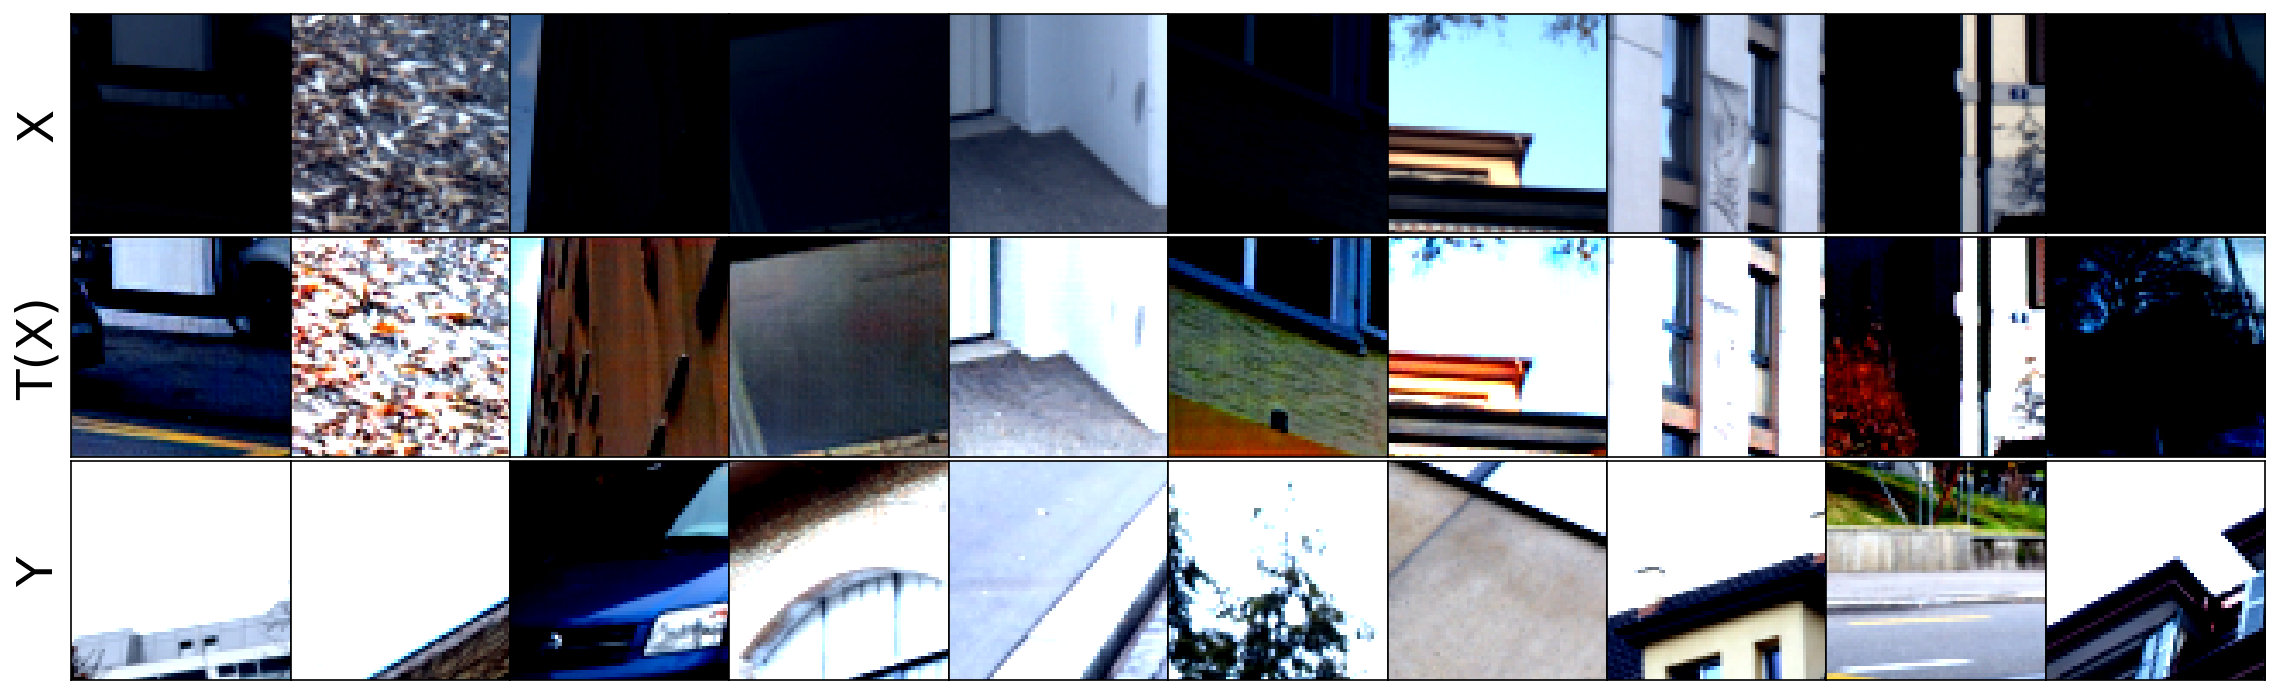

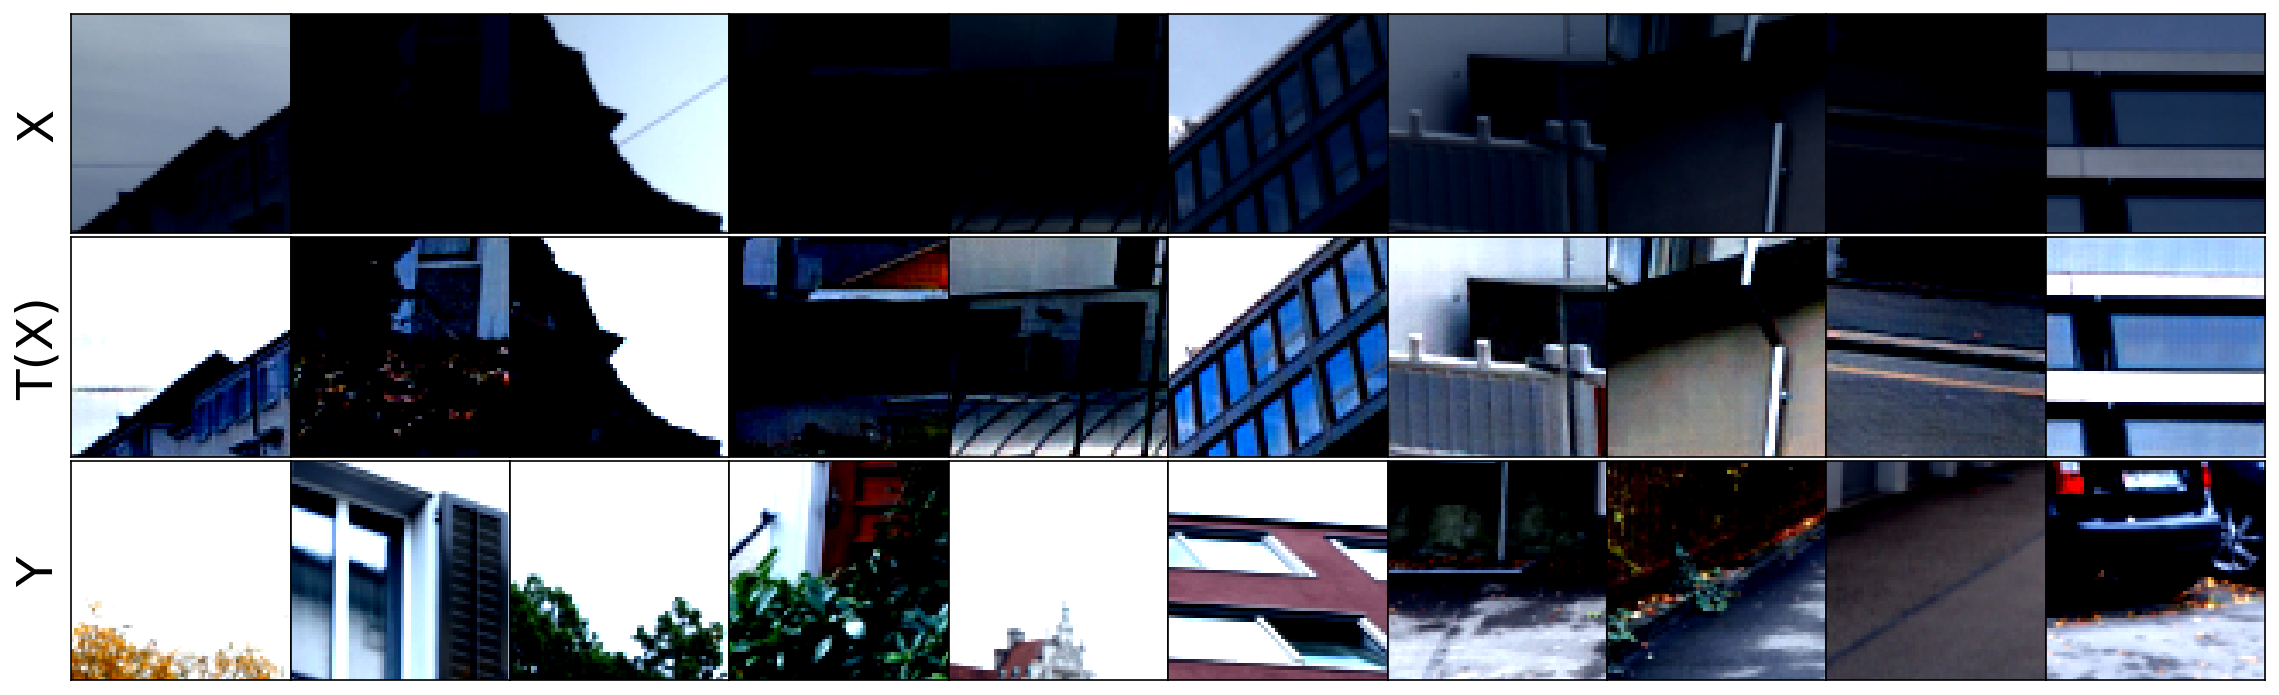

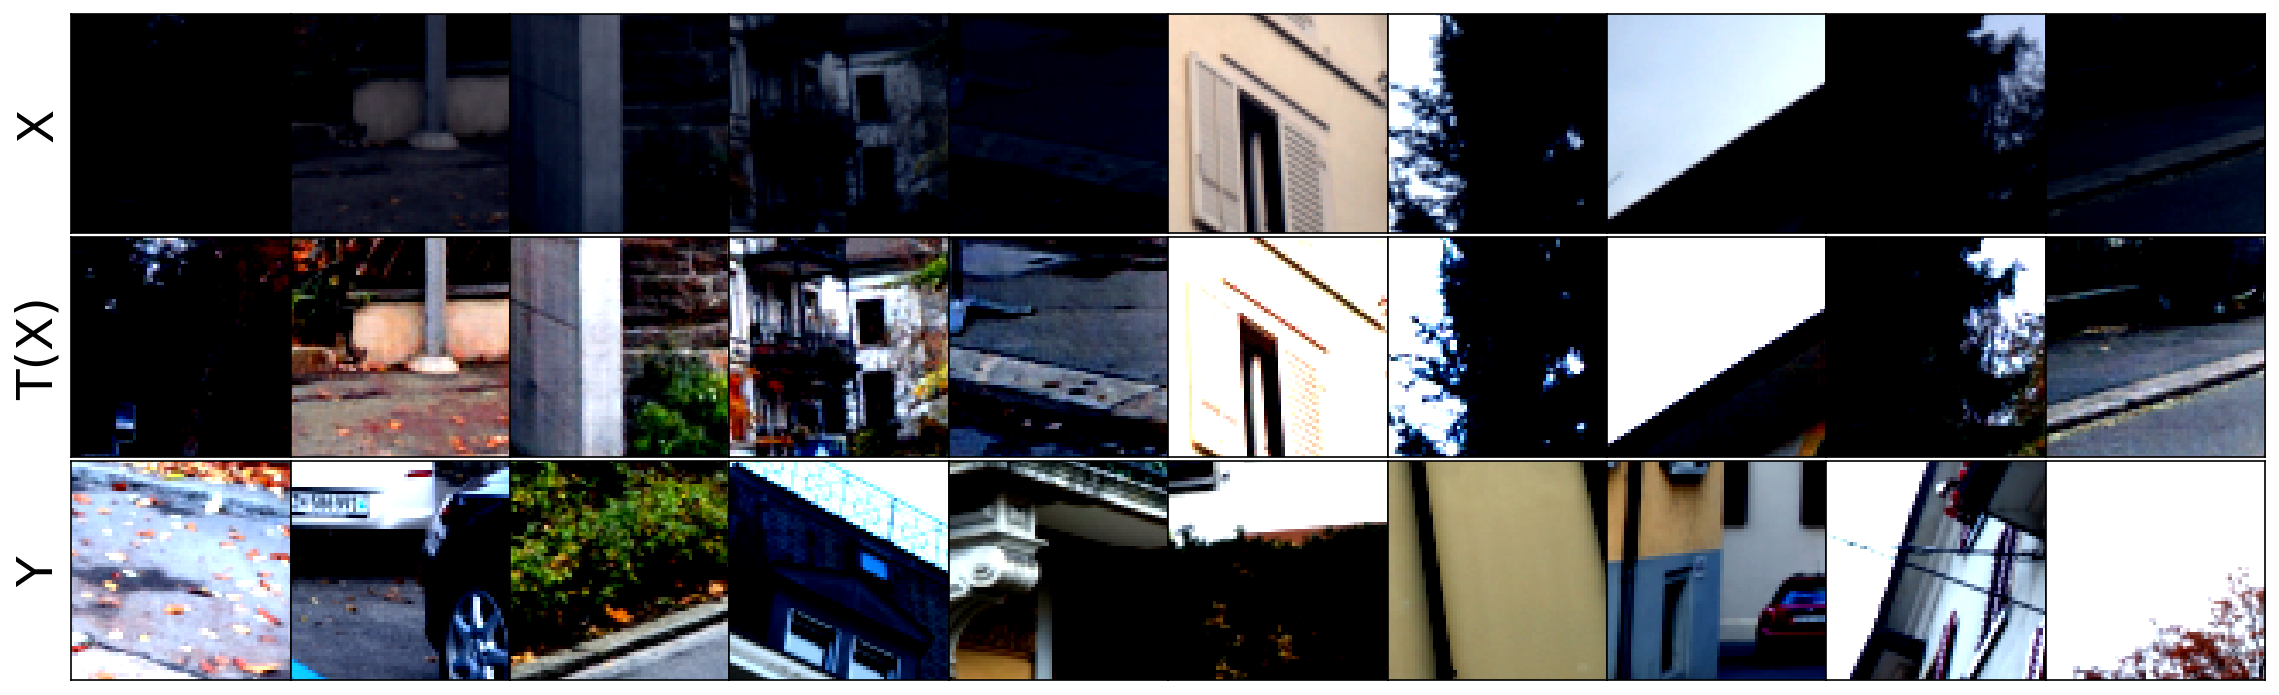

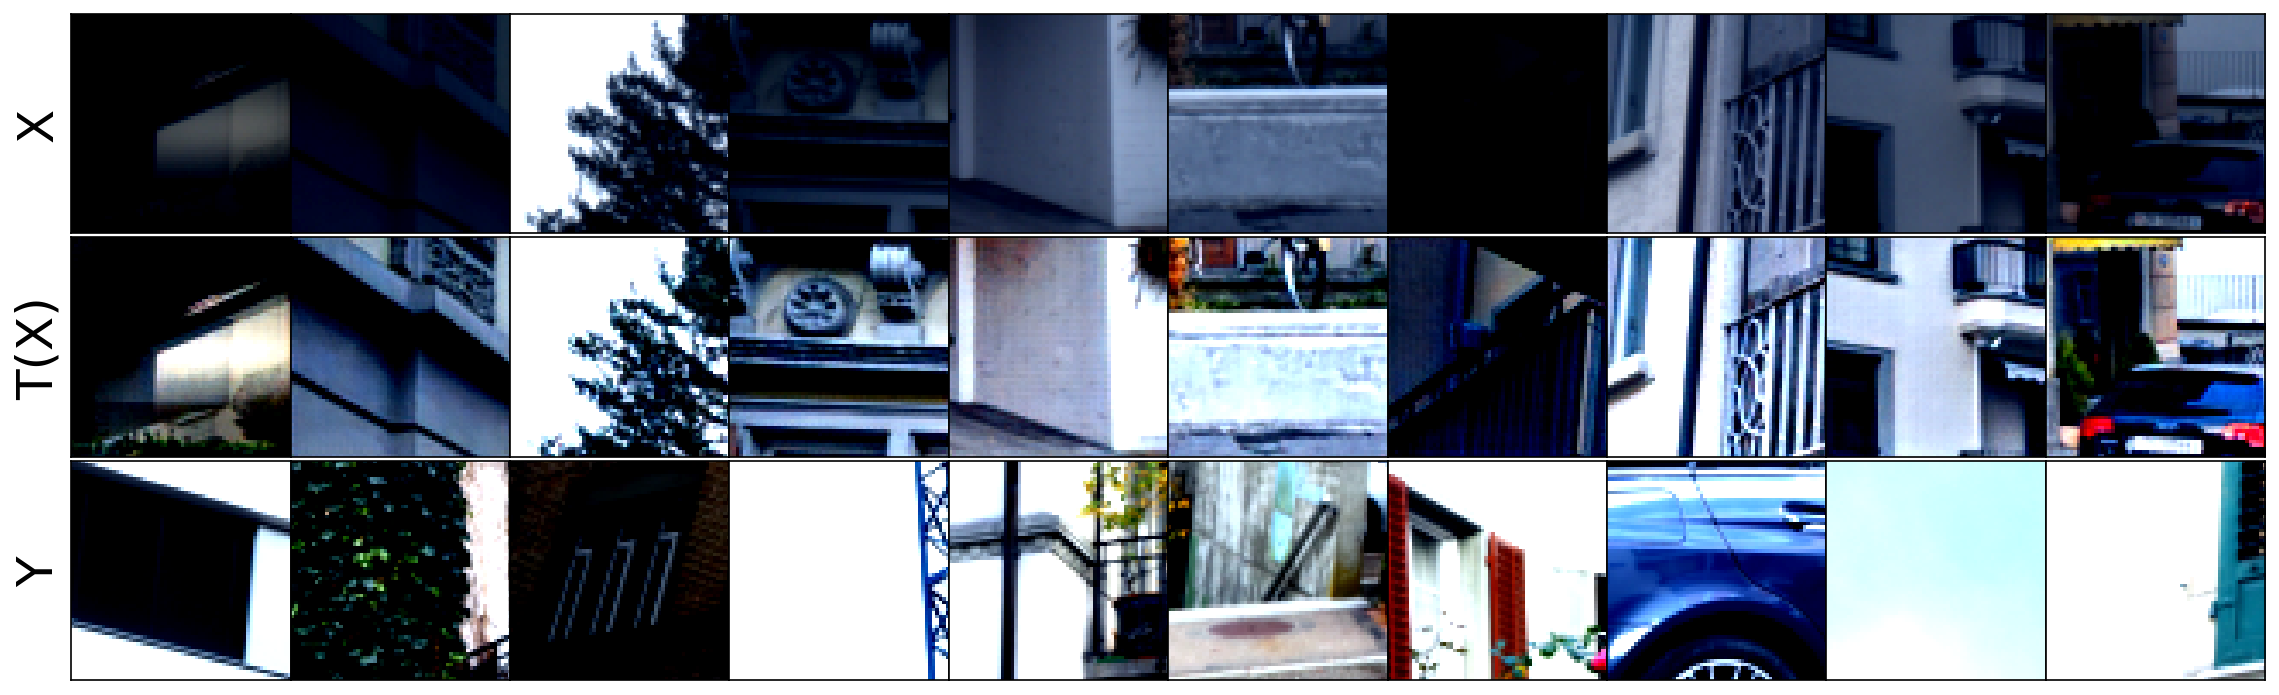

In [23]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
plt.show(fig); plt.close(fig) 
        
fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
plt.show(fig); plt.close(fig) 
        
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
plt.show(fig); plt.close(fig) 

fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
plt.show(fig); plt.close(fig)